In [1]:
import anndata as ad
import scanpy as sc
import squidpy as sq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import stats
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list, fcluster

import seaborn as sns
import gseapy as gp
import matplotlib.colors as mcolors

In [2]:
fdata = ad.read_h5ad("./RNA/Multitime_sorted.h5")
cdata = ad.read_h5ad("./RNA/Multitime.fixed.guide.h5")

In [3]:
fdata_2 = fdata[fdata.obs["time_point"] == "2"].copy()
cdata_2 = cdata[cdata.obs["time_point"] == "2"].copy()

In [12]:
np.sum([(x[0] == y[0]) & (x[1] == y[1]) for x, y in zip(fdata.obsm["spatial"], cdata.obsm["spatial"])])

66509

# major_clone

In [5]:
threshold = np.quantile(cdata_2.X, 0.999)
threshold

17.0

In [30]:
count_major = {}
for guide in cdata.var_names:
    count_major[guide] = cdata[cdata[:, guide].X > threshold].shape[0]
count_major = pd.DataFrame(count_major, index=["number_of_bins"])

<Figure size 1000x800 with 0 Axes>

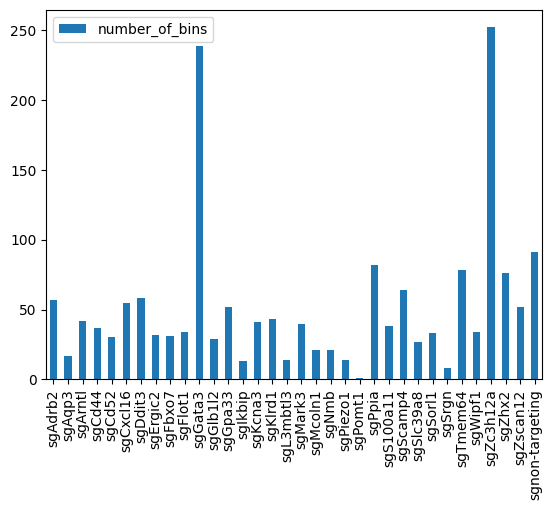

In [31]:
plt.figure(figsize=(10, 8))
count_major.T.plot(kind="bar")
plt.show()

In [89]:
proportion_df = {}
for guide in cdata.var_names:
    mask = (cdata_2[:, guide].X > threshold)
    proportion_df[guide] = (fdata_2[mask].obs["cluster_cellcharter_givenk"]).value_counts()
proportion_df = pd.DataFrame(proportion_df)
proportion_df = proportion_df.T.fillna(0)

proportion_df = (proportion_df.T / proportion_df.T.sum(axis=0)).T
proportion_df.dropna(inplace=True)

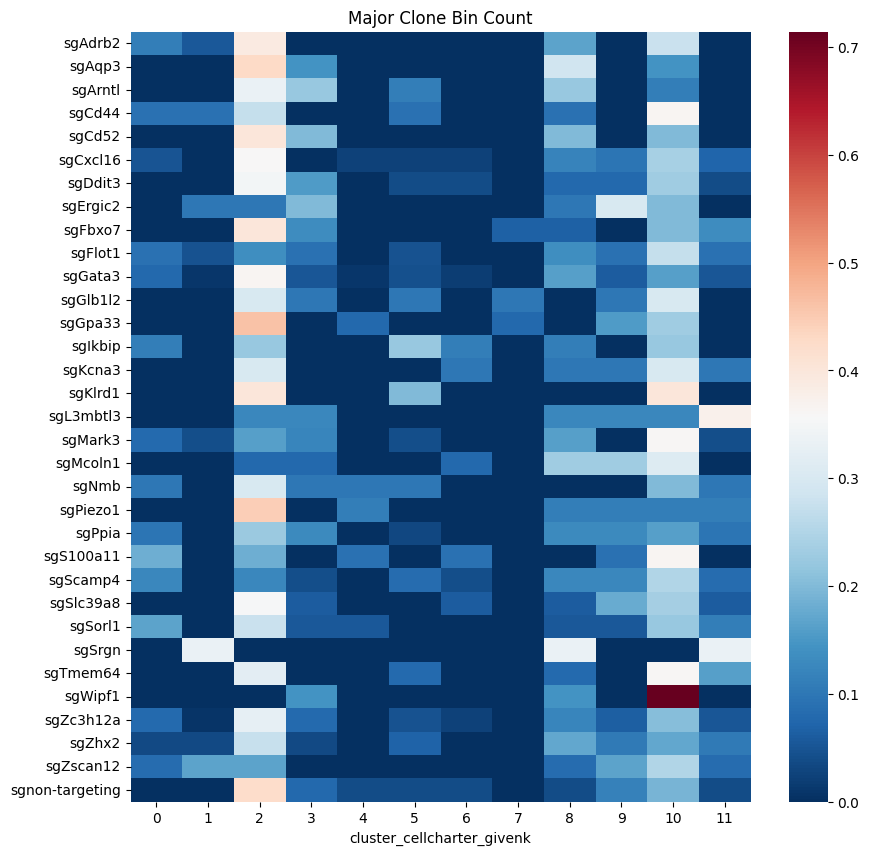

In [92]:
plt.figure(figsize=(10, 10))
sns.heatmap(proportion_df, cmap="RdBu_r")
plt.title("Major Clone Bin Count")
plt.show()

In [62]:
proportion_df = {}
for cluster in np.unique(fdata_2.obs["cluster_cellcharter_givenk"]):
    proportion_df[cluster] = cdata_2[mask.T[0] & (fdata_2.obs["cluster_cellcharter_givenk"] == cluster).tolist()].X.sum(axis=0).tolist()
proportion_df = pd.DataFrame(proportion_df)
proportion_df.index = cdata.var_names
proportion_df = proportion_df.T.fillna(0)
proportion_df

proportion_df = (proportion_df / proportion_df.sum(axis=0))
proportion_df.dropna(inplace=True)

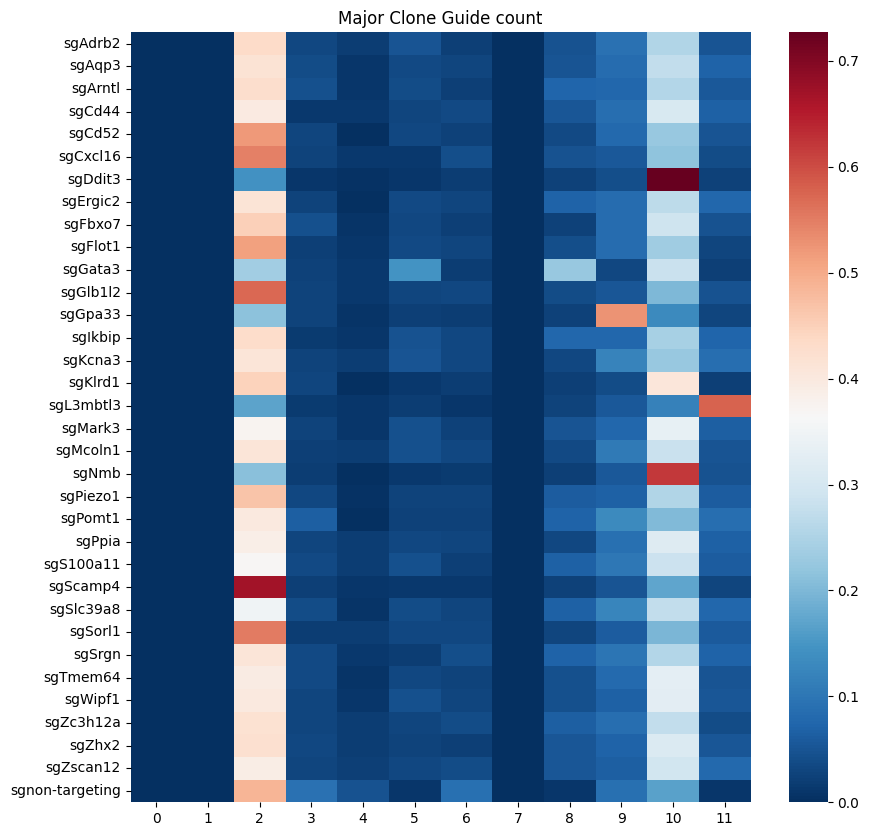

In [88]:
plt.figure(figsize=(10, 10))
sns.heatmap(proportion_df.T, cmap="RdBu_r")
plt.title("Major Clone Guide count")
plt.show()

In [10]:
from bin import load_bgi as ld

In [11]:
ddata = ld.load_bin("../20240602-T/B924.mapped.cut.gem", bin_size=20, library_id="map")

In [14]:
Fibroblasts = ["Col1a1", "Col1a2", "Col3a1","Mmp2", "Myl9", "Dcn","Fap"]
sc.tl.score_genes(fdata_2, Fibroblasts, score_name="fibro_score")

/tmp/ipykernel_42108/1836186700.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab20", 34)


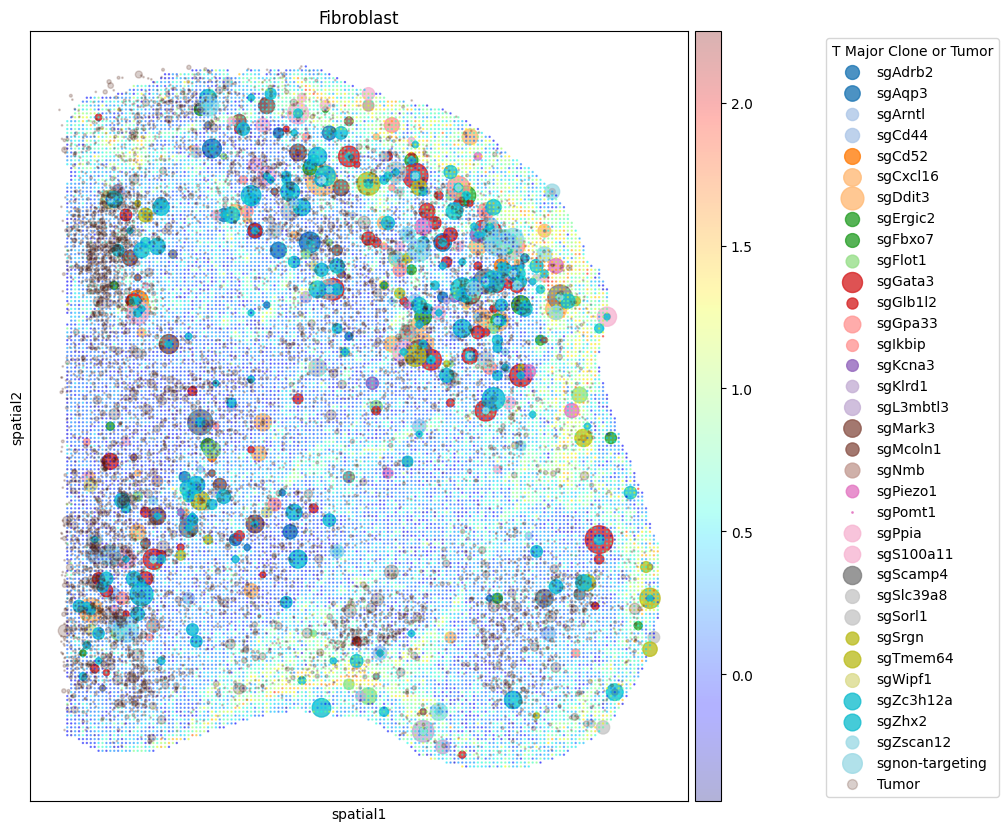

In [20]:
fig, ax = plt.subplots(figsize=(10, 10))

colors = plt.cm.get_cmap("tab20", 34)
color_map = {f"{cdata.var_names[i]}": colors(i) for i in range(34)}

for guide in cdata.var_names:
    mask = (cdata_2[:, guide].X > threshold)
    x = cdata_2[mask].obsm["spatial"][:, 0]
    y = cdata_2[mask].obsm["spatial"][:, 1]
    a = (cdata_2[mask, guide].X.flatten()).tolist()
    ax.scatter(x, y, s=a, alpha=0.8, color=color_map[guide], label=guide)

plt.legend(bbox_to_anchor=(1.05, 1), loc='best', ncol=2)
sq.pl.spatial_scatter(fdata_2, color="fibro_score", size=2, alpha=0.3, cmap="jet", shape=None, library_id="spatial", ax=ax, legend_loc=None)
x = ddata.obsm["spatial"][:, 0]
y = ddata.obsm["spatial"][:, 1]
a = ddata[:,"tdTomato"].X.toarray().flatten()
ax.scatter(x, y, s=np.square(a), alpha=0.2, color="#441100", label="Tumor")
ax.set_title("Fibroblast")
plt.legend(title='T Major Clone or Tumor', bbox_to_anchor=(1.2, 1), loc='upper left')
plt.show()

# sgCxcl16

In [105]:
mask = (cdata_2[:, "sgCxcl16"].X > threshold)
major_clone = fdata_2[mask].copy()
major_clone

AnnData object with n_obs × n_vars = 42 × 16001
    obs: 'time_point', 'n_genes', 'n_counts', '_scvi_batch', '_scvi_labels', 'cluster_cellcharter_givenk', 'spatial_cov'
    var: 'mt', 'mt-', 'gm', 'Rb', 'rik'
    uns: '_cellcharter', '_scvi_manager_uuid', '_scvi_uuid', 'cluster_cellcharter_givenk_colors', 'log1p', 'rank_genes_groups', 'spatial_neighbors'
    obsm: 'X_cellcharter', 'X_scVI', 'spatial'
    layers: 'counts'
    obsp: 'spatial_connectivities', 'spatial_distances'

In [106]:
sc.pp.pca(major_clone)

/tmp/ipykernel_76081/3185371579.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(unique_clusters))


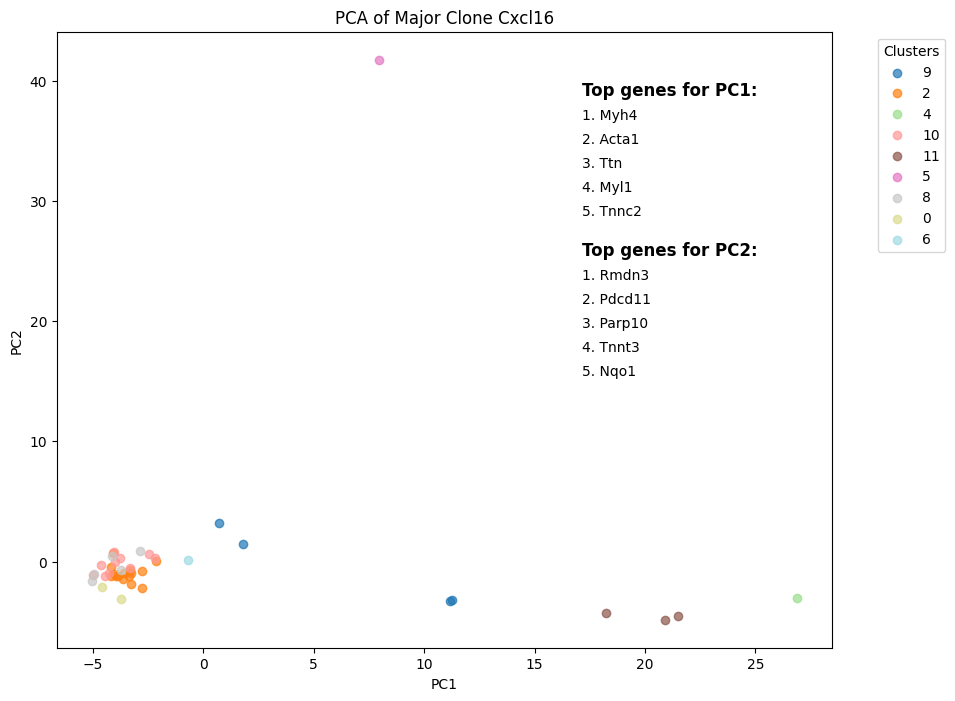

In [148]:
pca_result = major_clone.obsm['X_pca']
clusters = major_clone.obs["cluster_cellcharter_givenk"]

unique_clusters = clusters.unique()
colors = plt.cm.get_cmap('tab20', len(unique_clusters))
color_map = {cluster: colors(i) for i, cluster in enumerate(unique_clusters)}

loadings = pd.DataFrame(major_clone.varm['PCs'], index=major_clone.var_names)

top_genes_pc1 = loadings.iloc[:, 0].abs().sort_values(ascending=False).head(5)
top_genes_pc2 = loadings.iloc[:, 1].abs().sort_values(ascending=False).head(5)

plt.figure(figsize=(10, 8))
for cluster in unique_clusters:
    idx = clusters == cluster
    plt.scatter(pca_result[idx, 0], pca_result[idx, 1], label=cluster, color=color_map[cluster], alpha=0.7)

plt.figtext(0.65, 0.8, 'Top genes for PC1:', fontsize=12, fontweight='bold')
for i, gene in enumerate(top_genes_pc1.index, 1):
    plt.figtext(0.65, 0.8 - i*0.03, f'{i}. {gene}', fontsize=10)

plt.figtext(0.65, 0.6, 'Top genes for PC2:', fontsize=12, fontweight='bold')
for i, gene in enumerate(top_genes_pc2.index, 1):
    plt.figtext(0.65, 0.6 - i*0.03, f'{i}. {gene}', fontsize=10)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Major Clone Cxcl16')
plt.legend(title='Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [93]:
n_components = 3
pca_loadings = pd.DataFrame(major_clone.varm['PCs'][:, :n_components],
                            index=major_clone.var_names,
                            columns=[f'PC{i+1}' for i in range(n_components)])
for i in range(n_components):
    print(f"Top genes for PC{i+1}:")
    print(pca_loadings[f'PC{i+1}'].sort_values(ascending=False).head(10))

Top genes for PC1:
Myh4     0.114320
Acta1    0.108277
Ttn      0.105724
Myl1     0.105013
Tnnc2    0.104783
Mylpf    0.103487
Myh1     0.100921
Tnni2    0.099605
Car3     0.098387
Tnnt3    0.097473
Name: PC1, dtype: float64
Top genes for PC2:
Rmdn3       0.065064
Pdcd11      0.058694
Parp10      0.058640
Nqo1        0.056402
Hgs         0.056238
Pacsin3     0.054956
Kat2a       0.054547
Inpp5k      0.054275
Atp6v1e1    0.052238
Prkcq       0.052132
Name: PC2, dtype: float64
Top genes for PC3:
Col1a1      0.064608
Irf8        0.060399
Cxcl12      0.052271
Nrp1        0.050613
Sorl1       0.048805
B4galnt1    0.048683
Ctsh        0.047497
Ly9         0.046729
Ifngr1      0.046447
Mxd4        0.046389
Name: PC3, dtype: float64


# Other interesting guide

/tmp/ipykernel_76081/1279550496.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(unique_clusters))


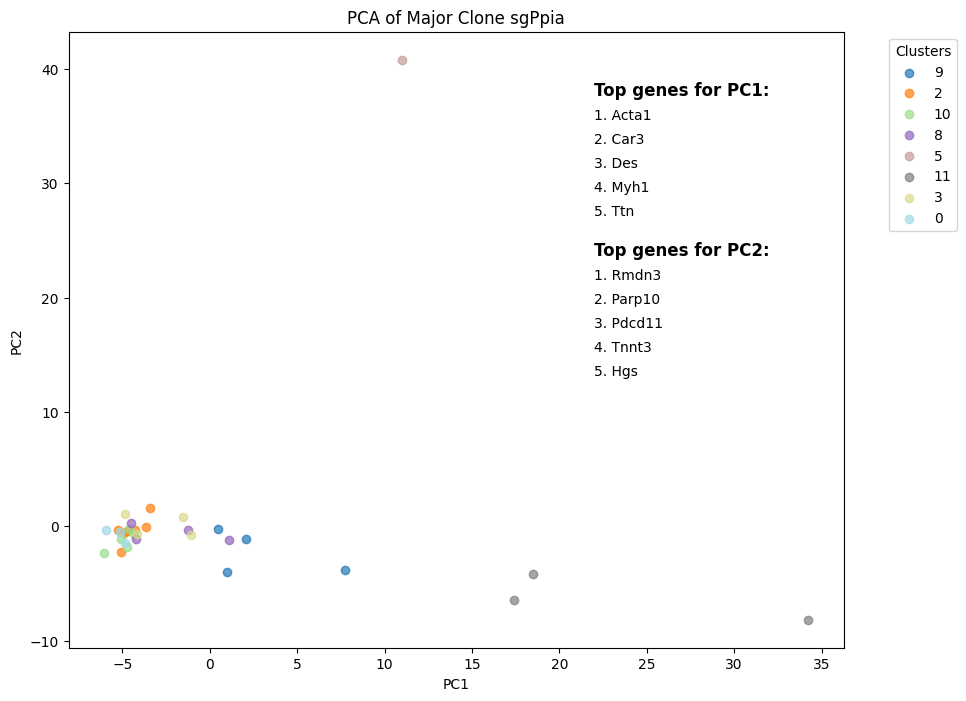

In [150]:
guide = "sgPpia"
mask = (cdata_2[:, guide].X > threshold)
major_clone = fdata_2[mask].copy()
sc.pp.pca(major_clone)

pca_result = major_clone.obsm['X_pca']
clusters = major_clone.obs["cluster_cellcharter_givenk"]

unique_clusters = clusters.unique()
colors = plt.cm.get_cmap('tab20', len(unique_clusters))
color_map = {cluster: colors(i) for i, cluster in enumerate(unique_clusters)}

loadings = pd.DataFrame(major_clone.varm['PCs'], index=major_clone.var_names)

top_genes_pc1 = loadings.iloc[:, 0].abs().sort_values(ascending=False).head(5)
top_genes_pc2 = loadings.iloc[:, 1].abs().sort_values(ascending=False).head(5)

plt.figure(figsize=(10, 8))
for cluster in unique_clusters:
    idx = clusters == cluster
    plt.scatter(pca_result[idx, 0], pca_result[idx, 1], label=cluster, color=color_map[cluster], alpha=0.7)

plt.figtext(0.65, 0.8, 'Top genes for PC1:', fontsize=12, fontweight='bold')
for i, gene in enumerate(top_genes_pc1.index, 1):
    plt.figtext(0.65, 0.8 - i*0.03, f'{i}. {gene}', fontsize=10)

plt.figtext(0.65, 0.6, 'Top genes for PC2:', fontsize=12, fontweight='bold')
for i, gene in enumerate(top_genes_pc2.index, 1):
    plt.figtext(0.65, 0.6 - i*0.03, f'{i}. {gene}', fontsize=10)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Major Clone ' + guide)
plt.legend(title='Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

/tmp/ipykernel_76081/3531672261.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(unique_clusters))


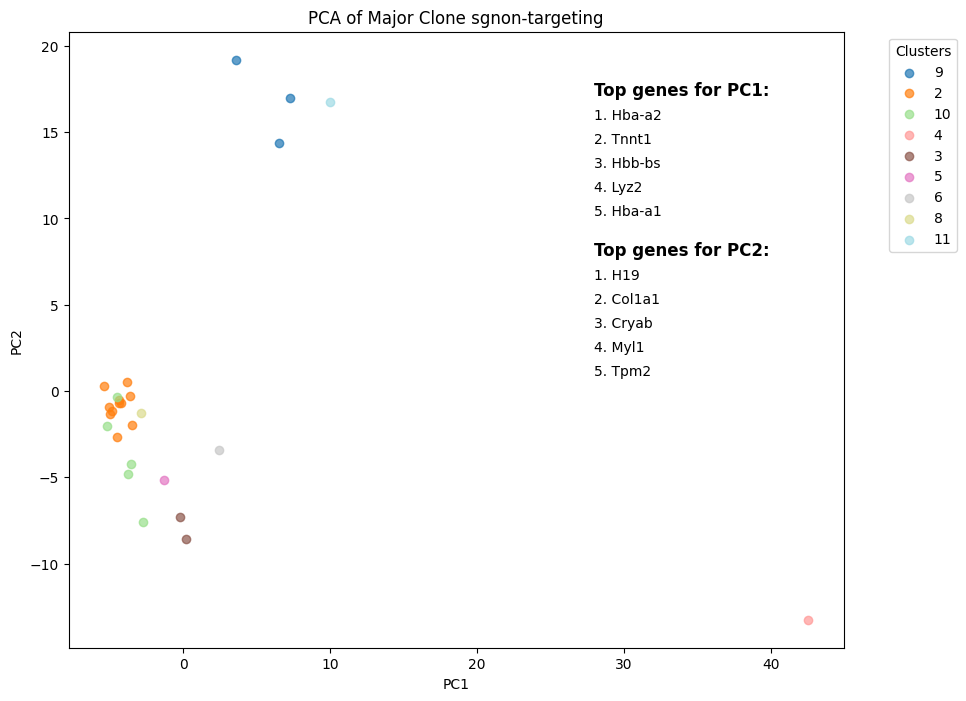

In [151]:
guide = "sgnon-targeting"
mask = (cdata_2[:, guide].X > threshold)
major_clone = fdata_2[mask].copy()
sc.pp.pca(major_clone)

pca_result = major_clone.obsm['X_pca']
clusters = major_clone.obs["cluster_cellcharter_givenk"]

unique_clusters = clusters.unique()
colors = plt.cm.get_cmap('tab20', len(unique_clusters))
color_map = {cluster: colors(i) for i, cluster in enumerate(unique_clusters)}

loadings = pd.DataFrame(major_clone.varm['PCs'], index=major_clone.var_names)

top_genes_pc1 = loadings.iloc[:, 0].abs().sort_values(ascending=False).head(5)
top_genes_pc2 = loadings.iloc[:, 1].abs().sort_values(ascending=False).head(5)

plt.figure(figsize=(10, 8))
for cluster in unique_clusters:
    idx = clusters == cluster
    plt.scatter(pca_result[idx, 0], pca_result[idx, 1], label=cluster, color=color_map[cluster], alpha=0.7)

plt.figtext(0.65, 0.8, 'Top genes for PC1:', fontsize=12, fontweight='bold')
for i, gene in enumerate(top_genes_pc1.index, 1):
    plt.figtext(0.65, 0.8 - i*0.03, f'{i}. {gene}', fontsize=10)

plt.figtext(0.65, 0.6, 'Top genes for PC2:', fontsize=12, fontweight='bold')
for i, gene in enumerate(top_genes_pc2.index, 1):
    plt.figtext(0.65, 0.6 - i*0.03, f'{i}. {gene}', fontsize=10)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Major Clone ' + guide)
plt.legend(title='Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

/tmp/ipykernel_76081/3246070424.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(unique_clusters))


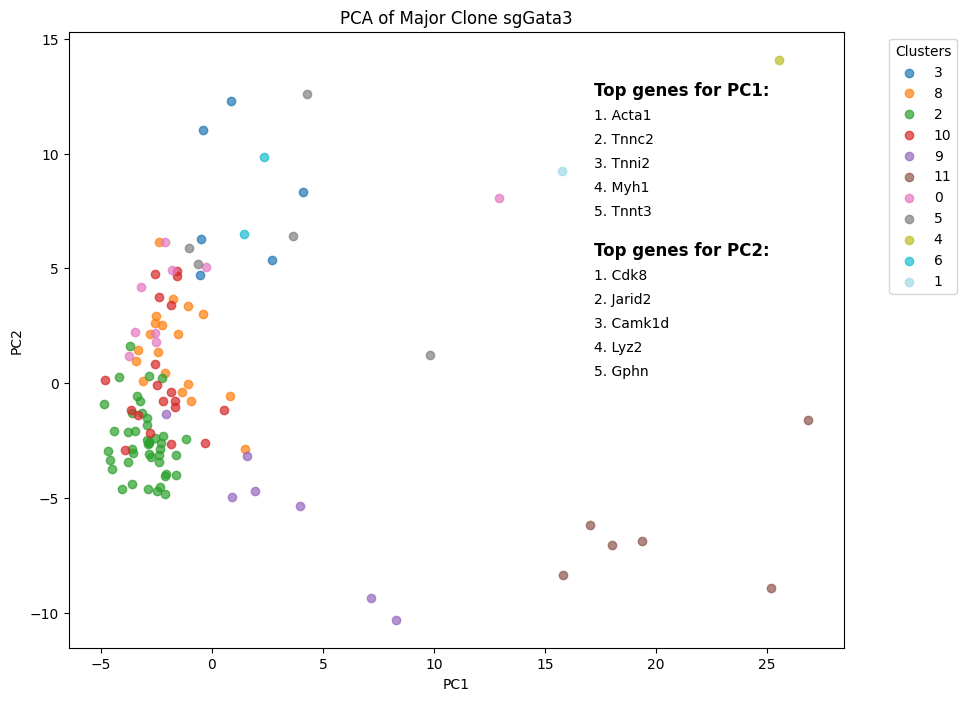

In [152]:
guide = "sgGata3"
mask = (cdata_2[:, guide].X > threshold)
major_clone = fdata_2[mask].copy()
sc.pp.pca(major_clone)

pca_result = major_clone.obsm['X_pca']
clusters = major_clone.obs["cluster_cellcharter_givenk"]

unique_clusters = clusters.unique()
colors = plt.cm.get_cmap('tab20', len(unique_clusters))
color_map = {cluster: colors(i) for i, cluster in enumerate(unique_clusters)}

loadings = pd.DataFrame(major_clone.varm['PCs'], index=major_clone.var_names)

top_genes_pc1 = loadings.iloc[:, 0].abs().sort_values(ascending=False).head(5)
top_genes_pc2 = loadings.iloc[:, 1].abs().sort_values(ascending=False).head(5)

plt.figure(figsize=(10, 8))
for cluster in unique_clusters:
    idx = clusters == cluster
    plt.scatter(pca_result[idx, 0], pca_result[idx, 1], label=cluster, color=color_map[cluster], alpha=0.7)

plt.figtext(0.65, 0.8, 'Top genes for PC1:', fontsize=12, fontweight='bold')
for i, gene in enumerate(top_genes_pc1.index, 1):
    plt.figtext(0.65, 0.8 - i*0.03, f'{i}. {gene}', fontsize=10)

plt.figtext(0.65, 0.6, 'Top genes for PC2:', fontsize=12, fontweight='bold')
for i, gene in enumerate(top_genes_pc2.index, 1):
    plt.figtext(0.65, 0.6 - i*0.03, f'{i}. {gene}', fontsize=10)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Major Clone ' + guide)
plt.legend(title='Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

/tmp/ipykernel_76081/2783897199.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(unique_clusters))


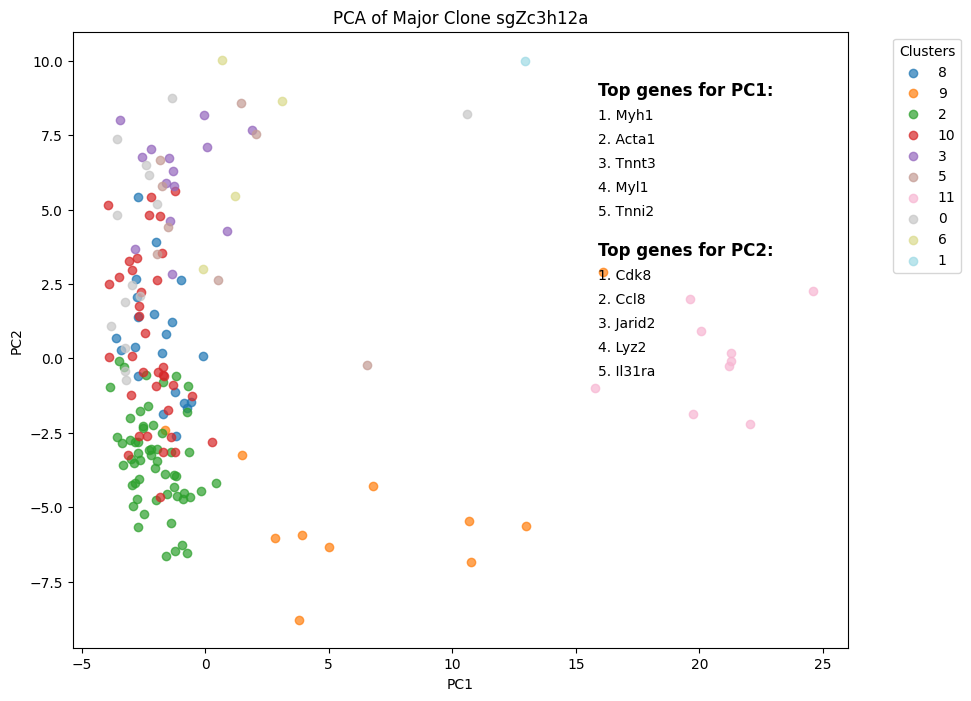

In [153]:
guide = "sgZc3h12a"
mask = (cdata_2[:, guide].X > threshold)
major_clone = fdata_2[mask].copy()
sc.pp.pca(major_clone)

pca_result = major_clone.obsm['X_pca']
clusters = major_clone.obs["cluster_cellcharter_givenk"]

unique_clusters = clusters.unique()
colors = plt.cm.get_cmap('tab20', len(unique_clusters))
color_map = {cluster: colors(i) for i, cluster in enumerate(unique_clusters)}

loadings = pd.DataFrame(major_clone.varm['PCs'], index=major_clone.var_names)

top_genes_pc1 = loadings.iloc[:, 0].abs().sort_values(ascending=False).head(5)
top_genes_pc2 = loadings.iloc[:, 1].abs().sort_values(ascending=False).head(5)

plt.figure(figsize=(10, 8))
for cluster in unique_clusters:
    idx = clusters == cluster
    plt.scatter(pca_result[idx, 0], pca_result[idx, 1], label=cluster, color=color_map[cluster], alpha=0.7)

plt.figtext(0.65, 0.8, 'Top genes for PC1:', fontsize=12, fontweight='bold')
for i, gene in enumerate(top_genes_pc1.index, 1):
    plt.figtext(0.65, 0.8 - i*0.03, f'{i}. {gene}', fontsize=10)

plt.figtext(0.65, 0.6, 'Top genes for PC2:', fontsize=12, fontweight='bold')
for i, gene in enumerate(top_genes_pc2.index, 1):
    plt.figtext(0.65, 0.6 - i*0.03, f'{i}. {gene}', fontsize=10)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Major Clone ' + guide)
plt.legend(title='Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()